In [1]:
import os, psutil
import gc

import numpy as np
import pandas as pd
import scipy as sci
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import sklearn
sklearn.set_config(transform_output="pandas")

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB 

from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_validate,cross_val_score,train_test_split, KFold, GridSearchCV, LearningCurveDisplay, ValidationCurveDisplay
from sklearn.metrics import classification_report, accuracy_score, log_loss, roc_auc_score, confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.metrics import fowlkes_mallows_score, homogeneity_completeness_v_measure, adjusted_mutual_info_score, normalized_mutual_info_score, adjusted_rand_score, rand_score
from sklearn import ensemble,metrics,model_selection,neighbors,preprocessing, svm, tree
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, TargetEncoder, StandardScaler, RobustScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline

import lightgbm as lgb
from lightgbm import LGBMClassifier

from statsmodels.graphics.mosaicplot import mosaic

from time import time
import warnings

import shap

from sklearn.cluster import KMeans, BisectingKMeans
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
%%time
# taken from https://www.kaggle.com/ryanholbrook/getting-started-september-2021-tabular-playground

def cpu_stats():
    pid = os.getpid()
    py = psutil.Process(pid)
    memory_use = py.memory_info()[0] / 2. ** 30
    return 'memory GB:' + str(np.round(memory_use, 2))

def score(X, y, model, cv, scoring = {"AUC_OVR_Weighted": "roc_auc_ovr_weighted","AUC_OVO_Weighted": "roc_auc_ovo_weighted", "Accuracy": "accuracy"}):
    scores = cross_validate(
        model, X, y, scoring=scoring, cv=cv, return_train_score=True
    )
    scores = pd.DataFrame(scores).T
    return scores.assign(
        mean = lambda x: x.mean(axis=1),
        std = lambda x: x.std(axis=1),
    )
print('Function built')

Function built
CPU times: total: 0 ns
Wall time: 0 ns


In [3]:
%%time

## from: https://www.kaggle.com/bextuychiev/how-to-work-w-million-row-datasets-like-a-pro
def reduce_memory_usage(df, verbose=True):
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                        c_min > np.finfo(np.float16).min
                        and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                        c_min > np.finfo(np.float32).min
                        and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

CPU times: total: 0 ns
Wall time: 0 ns


In [4]:
# Modified from HW 5 Q2 Part a.
def train_and_evaluate_classifier(name, clf, X_train, y_train, X_test, y_test, cv=5, debug=False, learning_curve=False, confusion=False, supress_outputs=True):
  print(name)
    
  t0 = time()
  # Fit your classifier on the training set
  ### START CODE ###
  clf.fit(X_train, y_train)
  ### END CODE ###
  if supress_outputs == False:
      print("training time", round(time()-t0, 3), "s")

  t0 = time()
  y_train_pred = clf.predict(X_train)
  y_test_pred = clf.predict(X_test)
  if supress_outputs == False:
      print("predict time", round(time()-t0, 3), "s")

  if supress_outputs == False:
    print("Confusion matrix: ")
  # Print the confusion matrix computed from the test set (1 line of code only)
  ### START CODE ###
  #print(confusion_matrix(y_test, y_pred))
  # ConfusionMatrixDisplay.from_estimator(clf, X_train, y_train)
  if confusion == True:
      ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)
      plt.show()
  ### END CODE ###


  ### START CODE ###
  y_train_pred_proba = clf.predict_proba(X_train)
  y_test_pred_proba = clf.predict_proba(X_test)
    
  if debug == True:
      print(y_test_pred_proba)

  train_acc_score = accuracy_score(y_train, y_train_pred)
  test_acc_score = accuracy_score(y_test, y_test_pred)

  train_auc_score_ovo = roc_auc_score(y_train, y_train_pred_proba, multi_class='ovo')  
  train_auc_score_ovr = roc_auc_score(y_train, y_train_pred_proba, multi_class='ovr')
    
  test_auc_score_ovo = roc_auc_score(y_test, y_test_pred_proba, multi_class='ovo')  
  test_auc_score_ovr = roc_auc_score(y_test, y_test_pred_proba, multi_class='ovr')
  ### END CODE ###
    
  if supress_outputs == False:
      print("TRAIN - Accuracy: {}, AUC_ROC_OVO: {}, AUC_ROC_OVR: {}".format(train_acc_score, train_auc_score_ovo, train_auc_score_ovr))
      print("TEST - Accuracy: {}, AUC_ROC_OVO: {}, AUC_ROC_OVR: {}".format(test_acc_score, test_auc_score_ovo, test_auc_score_ovr))

  # Display Learning curve
  if learning_curve == True:
      LearningCurveDisplay.from_estimator(clf, X_train, y_train, scoring='accuracy')
  #RocCurveDisplay.from_estimator(clf, X_test, y_test)

  train_results = [train_acc_score, train_auc_score_ovo, train_auc_score_ovr]
  test_results = [test_acc_score, test_auc_score_ovo, test_auc_score_ovr]
  return train_results, test_results

In [5]:
df1 = pd.read_csv('dataset/ObesityDataSet.csv')

df2 = pd.read_csv('dataset/train.csv')
df2 = df2.drop(columns='id')

df = pd.concat([df1, df2], ignore_index=True)
df

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.000000,1.620000,64.000000,yes,no,2.000000,3.000000,Sometimes,no,2.000000,no,0.000000,1.000000,no,Public_Transportation,Normal_Weight
1,Female,21.000000,1.520000,56.000000,yes,no,3.000000,3.000000,Sometimes,yes,3.000000,yes,3.000000,0.000000,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.000000,1.800000,77.000000,yes,no,2.000000,3.000000,Sometimes,no,2.000000,no,2.000000,1.000000,Frequently,Public_Transportation,Normal_Weight
3,Male,27.000000,1.800000,87.000000,no,no,3.000000,3.000000,Sometimes,no,2.000000,no,2.000000,0.000000,Frequently,Walking,Overweight_Level_I
4,Male,22.000000,1.780000,89.800000,no,no,2.000000,1.000000,Sometimes,no,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22864,Male,25.137087,1.766626,114.187096,yes,yes,2.919584,3.000000,Sometimes,no,2.151809,no,1.330519,0.196680,Sometimes,Public_Transportation,Obesity_Type_II
22865,Male,18.000000,1.710000,50.000000,no,yes,3.000000,4.000000,Frequently,no,1.000000,no,2.000000,1.000000,Sometimes,Public_Transportation,Insufficient_Weight
22866,Male,20.101026,1.819557,105.580491,yes,yes,2.407817,3.000000,Sometimes,no,2.000000,no,1.158040,1.198439,no,Public_Transportation,Obesity_Type_II
22867,Male,33.852953,1.700000,83.520113,yes,yes,2.671238,1.971472,Sometimes,no,2.144838,no,0.000000,0.973834,no,Automobile,Overweight_Level_II


In [6]:
df['BMI'] = df['Weight'] / (df['Height'] ** 2)
# df['BMI'].hist()
# df['BMI'].describe()

In [7]:
WHObmi_boys = pd.read_csv("dataset/bmi_boys_perc_WHO2007.csv")
WHObmi_girls = pd.read_csv("dataset/bmi_girls_perc_WHO2007.csv")

CDCbmi_boys = pd.read_csv("dataset/bmiagerev_boys.csv")
CDCbmi_girls = pd.read_csv("dataset/bmiagerv_girls.csv")

In [8]:
WHObmi_boys.insert(0, "Age", WHObmi_boys['Month']/12)
WHObmi_boys = WHObmi_boys[WHObmi_boys['Age'] >= 14]

WHObmi_girls.insert(0, "Age", WHObmi_girls['Month']/12)
WHObmi_girls = WHObmi_girls[WHObmi_girls['Age'] >= 14]

CDCbmi_boys.insert(0, "Age", CDCbmi_boys['Agemos']/12)
CDCbmi_boys = CDCbmi_boys[CDCbmi_boys['Age'] >= 14]

CDCbmi_girls.insert(0, "Age", CDCbmi_girls['Agemos']/12)
CDCbmi_girls = CDCbmi_girls[CDCbmi_girls['Age'] >= 14]

In [9]:
df['Adult'] = np.select([df['Age'] >= 20, df['Age'] < 20], ["True", "False"]) 

# from https://www.dataquest.io/blog/tutorial-add-column-pandas-dataframe-based-on-if-else-condition/
# create a list of our conditions
conditions = [
    (df['Adult'] == "False"),
    (df['Adult'] == "True") & (df['BMI'] < 18.5),
    (df['Adult'] == "True") & (df['BMI'] >= 18.5) & (df['BMI'] < 25),
    (df['Adult'] == "True") & (df['BMI'] >= 25) & (df['BMI'] < 30),
    (df['Adult'] == "True") & (df['BMI'] >= 30) & (df['BMI'] < 35),
    (df['Adult'] == "True") & (df['BMI'] >= 35) & (df['BMI'] < 40),
    (df['Adult'] == "True") & (df['BMI'] >= 40)
    ]

# create a list of the values we want to assign for each condition
values = ['N/A', 'underweight', 'healthy', 'overweight', 'obseity class 1', 'obseity class 2', 'obseity class 3']

# create a new column and use np.select to assign values to it using our lists as arguments
df['Adult BMI Predictions'] = np.select(conditions, values)

In [10]:
WHOBMI_pred = []
CDCBMI_pred = []
df_temp = df[df['Adult'] == "False"]
df_needed = df_temp[['Gender', 'Age', 'BMI']]
for index, row in df_needed.iterrows():
    if row['Gender'] == "Male":
        WHO_entry = WHObmi_boys.loc[(WHObmi_boys.Age - row['Age']).abs().idxmin()]
        CDC_entry = CDCbmi_boys.loc[(CDCbmi_boys.Age - row['Age']).abs().idxmin()]

        for (pred, entry) in [(WHOBMI_pred, WHO_entry), (CDCBMI_pred, CDC_entry)]:
            if row['BMI'] < entry['P5']:
                pred.append('underweight')
            elif row['BMI'] >= entry['P5'] and row['BMI'] < entry['P85']:
                pred.append('healthy')
            elif row['BMI'] >= entry['P85'] and row['BMI'] < entry['P95']:
                pred.append('overweight')
            elif row['BMI'] >= entry['P95'] and row['BMI'] < (1.25 * entry['P95']):
                pred.append('obseity class 1')
            elif row['BMI'] >= (1.25 * entry['P95']) and row['BMI'] < (1.4 * entry['P95']):
                pred.append('obseity class 2')
            else:
                pred.append('obseity class 3')

    elif row['Gender'] == "Female":
        WHO_entry = WHObmi_girls.loc[(WHObmi_girls.Age - row['Age']).abs().idxmin()]
        CDC_entry = CDCbmi_girls.loc[(CDCbmi_girls.Age - row['Age']).abs().idxmin()]

        for (pred, entry) in [(WHOBMI_pred, WHO_entry), (CDCBMI_pred, CDC_entry)]:
            if row['BMI'] < entry['P5']:
                pred.append('underweight')
            elif row['BMI'] >= entry['P5'] and row['BMI'] < entry['P85']:
                pred.append('healthy')
            elif row['BMI'] >= entry['P85'] and row['BMI'] < entry['P95']:
                pred.append('overweight')
            elif row['BMI'] >= entry['P95'] and row['BMI'] < (1.25 * entry['P95']):
                pred.append('obseity class 1')
            elif row['BMI'] >= (1.25 * entry['P95']) and row['BMI'] < (1.4 * entry['P95']):
                pred.append('obseity class 2')
            else:
                pred.append('obseity class 3')
        
# df_temp['WHO BMI Predictions'] = WHOBMI_pred
# df_temp['CDC BMI Predicitons'] = CDCBMI_pred
# df_temp

In [11]:
df['WHO BMI Predictions'] = 'N/A'
df['CDC BMI Predictions'] = 'N/A'

df.loc[df['Adult'] == 'False', 'WHO BMI Predictions'] = WHOBMI_pred
df.loc[df['Adult'] == 'False', 'CDC BMI Predictions'] = CDCBMI_pred
# df

In [12]:
df_lean = reduce_memory_usage(df.copy(), verbose=True)
# test = reduce_memory_usage(test, verbose=True)
print(cpu_stats())
print('Memory reduced')

Mem. usage decreased to 2.66 Mb (30.7% reduction)
memory GB:0.24
Memory reduced


features obtained


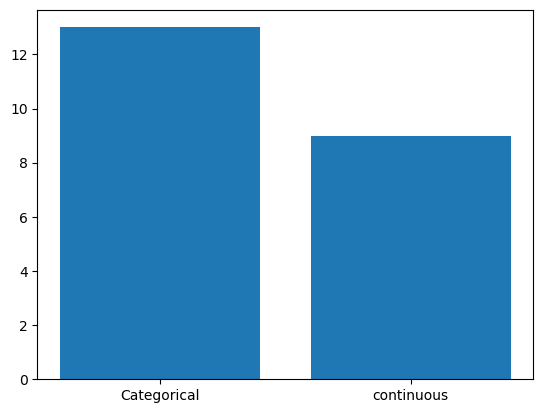

CPU times: total: 93.8 ms
Wall time: 98.4 ms


In [13]:
%%time
features=[]
cat_features=[]
cont_features=[]
for feature in df_lean.columns:
    features.append(feature)
    if df_lean.dtypes[feature] in ['int8', 'object', 'bool']:
        cat_features.append(feature)
    if df_lean.dtypes[feature]=='float16':
        cont_features.append(feature)
    #print(test.dtypes[feature])
print('features obtained')

plt.bar([1,2],[len(cat_features),len(cont_features)])
plt.xticks([1,2],('Categorical','continuous'))
plt.show()

In [14]:
y = df['NObeyesdad']
X = df.drop(columns='NObeyesdad')

y_lean = df_lean['NObeyesdad']
X_lean = df_lean.drop(columns='NObeyesdad')

In [15]:
cat_features.remove('NObeyesdad')
cat_features

['Gender',
 'family_history_with_overweight',
 'FAVC',
 'CAEC',
 'SMOKE',
 'SCC',
 'CALC',
 'MTRANS',
 'Adult',
 'Adult BMI Predictions',
 'WHO BMI Predictions',
 'CDC BMI Predictions']

In [16]:
nominal_features = [cat_features[i] for i in [0, 1, 2, 4, 5, 7, 9]]
print(nominal_features)

ordinal_features = [cat_features[i] for i in [3, 6, 9, 10, 11]]
print(ordinal_features)

['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC', 'MTRANS', 'Adult BMI Predictions']
['CAEC', 'CALC', 'Adult BMI Predictions', 'WHO BMI Predictions', 'CDC BMI Predictions']


In [17]:
cont_features

['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'BMI']

In [18]:
cat_features

['Gender',
 'family_history_with_overweight',
 'FAVC',
 'CAEC',
 'SMOKE',
 'SCC',
 'CALC',
 'MTRANS',
 'Adult',
 'Adult BMI Predictions',
 'WHO BMI Predictions',
 'CDC BMI Predictions']

In [19]:
ordinal_features

['CAEC',
 'CALC',
 'Adult BMI Predictions',
 'WHO BMI Predictions',
 'CDC BMI Predictions']

In [20]:
nominal_features

['Gender',
 'family_history_with_overweight',
 'FAVC',
 'SMOKE',
 'SCC',
 'MTRANS',
 'Adult BMI Predictions']

In [21]:
for cat_feat in cat_features:
    print(X[cat_feat].unique())

['Female' 'Male']
['yes' 'no']
['no' 'yes']
['Sometimes' 'Frequently' 'Always' 'no']
['no' 'yes']
['no' 'yes']
['no' 'Sometimes' 'Frequently' 'Always']
['Public_Transportation' 'Walking' 'Automobile' 'Motorbike' 'Bike']
['True' 'False']
['healthy' 'overweight' 'obseity class 1' 'N/A' 'underweight'
 'obseity class 2' 'obseity class 3']
['N/A' 'healthy' 'overweight' 'obseity class 1' 'underweight'
 'obseity class 3' 'obseity class 2']
['N/A' 'healthy' 'underweight' 'obseity class 1' 'overweight'
 'obseity class 3' 'obseity class 2']


In [22]:
# Manual encoding
manual_enc = ColumnTransformer(
    [
        ('numerical', 'passthrough', cont_features),
        ('ordinal', OrdinalEncoder(categories=[
            ['no', 'Sometimes', 'Frequently', 'Always'],
            ['no', 'Sometimes', 'Frequently', 'Always'],
            ['N/A', 'underweight', 'healthy', 'overweight', 'obseity class 1', 'obseity class 2', 'obseity class 3'],
            ['N/A', 'underweight', 'healthy', 'overweight', 'obseity class 1', 'obseity class 2', 'obseity class 3'],
            ['N/A', 'underweight', 'healthy', 'overweight', 'obseity class 1', 'obseity class 2', 'obseity class 3']
        ]), ordinal_features),
        ('nominal', OneHotEncoder(sparse_output=False), nominal_features)
    ]
)

In [23]:
# Manual encoding
col_enc1 = ColumnTransformer(
    [
        ('numerical', 'passthrough', cont_features),
        ('ordinal', OrdinalEncoder(categories=[
            ['no', 'Sometimes', 'Frequently', 'Always'],
            ['no', 'Sometimes', 'Frequently', 'Always'],
            ['N/A', 'underweight', 'healthy', 'overweight', 'obseity class 1', 'obseity class 2', 'obseity class 3'],
            ['N/A', 'underweight', 'healthy', 'overweight', 'obseity class 1', 'obseity class 2', 'obseity class 3'],
            ['N/A', 'underweight', 'healthy', 'overweight', 'obseity class 1', 'obseity class 2', 'obseity class 3']
        ]), ordinal_features),
        ('nominal', OneHotEncoder(sparse_output=False), nominal_features)
    ], verbose_feature_names_out=False
)

In [24]:
col_enc2 = ColumnTransformer(
    [
        ('numerIteract', Pipeline(
            [
                ('interact', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
                ('scale', StandardScaler())
            ]), slice(0, 9)),
        ('catInteract', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False), slice(14, 31))
    ], verbose_feature_names_out=False
)

manual_enc2 = Pipeline([('Categorical Preprocessing', col_enc1), ('Interaction Terms', col_enc2)])

In [25]:
ordinalCT = OrdinalEncoder()

ordinalCatOnlyCT = ColumnTransformer(
        [
            ("numerical", "passthrough", cont_features),
            ("categorical", OrdinalEncoder(), cat_features),
        ], verbose_feature_names_out=False
    )

ordinalCatStandardCT = ColumnTransformer(
        [
            ("numerical", StandardScaler(), cont_features),
            ("categorical", OrdinalEncoder(), cat_features),
        ], verbose_feature_names_out=False
    )

ordinalCatRobustCT = ColumnTransformer(
        [
            ("numerical", RobustScaler(), cont_features),
            ("categorical", OrdinalEncoder(), cat_features),
        ], verbose_feature_names_out=False
    )

# Removed due to memory issues
# oneHotCT = OneHotEncoder() 


oneHotCatOnlyCT = ColumnTransformer(
        [
            ("numerical", "passthrough", cont_features),
            ("categorical", OneHotEncoder(drop='if_binary', sparse_output=False), cat_features),
        ], verbose_feature_names_out=False
    )

oneHotCatStandardCT = ColumnTransformer(
        [
            ("numerical", StandardScaler(), cont_features),
            ("categorical", OneHotEncoder(drop='if_binary', sparse_output=False), cat_features),
        ], verbose_feature_names_out=False
    )

oneHotCatRobustCT = ColumnTransformer(
        [
            ("numerical", RobustScaler(), cont_features),
            ("categorical", OneHotEncoder(drop='if_binary', sparse_output=False), cat_features),
        ], verbose_feature_names_out=False
    )

CTs = [ordinalCT, ordinalCatOnlyCT, ordinalCatStandardCT, ordinalCatRobustCT, 
       # oneHotCT, 
       oneHotCatOnlyCT, oneHotCatStandardCT, oneHotCatRobustCT, manual_enc, manual_enc2]
preprocessed = ["(Ordinal)", "(Ordinal Categorical Only - No Scaling)", "(Ordinal Categorical Only - Standard Scaler)", "(Ordinal Categorical Only - Robust Scaler)",
                # "(One Hot)", 
                "(One Hot Categorical Only - No Scaling)", "(One Hot Categorical Only - Standard Scaler)", "(One Hot Categorical Only - Robust Scaler)",
               'Manual Encoding 1', 'Manual Encoding 2']

if len(CTs) != len(preprocessed):
    print("NUMBER OF TRANSFORMERS != NUMBER OF PREPROCESSED DATASETS") 

In [26]:
X.flags

<Flags(allows_duplicate_labels=True)>

In [27]:
X[X['Adult'] == 'False']

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,...,SCC,FAF,TUE,CALC,MTRANS,BMI,Adult,Adult BMI Predictions,WHO BMI Predictions,CDC BMI Predictions
28,Male,19.000000,1.750000,76.000000,yes,yes,3.000000,3.000000,Sometimes,no,...,yes,3.000000,1.000000,Sometimes,Public_Transportation,24.816327,False,N/A,healthy,healthy
58,Female,17.000000,1.650000,67.000000,yes,yes,3.000000,1.000000,Sometimes,no,...,no,1.000000,1.000000,no,Walking,24.609734,False,N/A,healthy,healthy
73,Male,19.000000,1.850000,65.000000,yes,no,2.000000,3.000000,Sometimes,no,...,no,2.000000,1.000000,Sometimes,Bike,18.991965,False,N/A,healthy,healthy
80,Female,19.000000,1.630000,58.000000,no,no,3.000000,3.000000,Sometimes,no,...,yes,0.000000,0.000000,no,Public_Transportation,21.829952,False,N/A,healthy,healthy
83,Female,19.000000,1.600000,45.000000,no,no,3.000000,3.000000,no,no,...,yes,2.000000,0.000000,no,Walking,17.578125,False,N/A,healthy,underweight
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22854,Female,19.000000,1.740000,78.000000,yes,yes,3.000000,1.000000,Sometimes,no,...,no,1.000000,0.000000,Sometimes,Public_Transportation,25.762981,False,N/A,overweight,healthy
22856,Female,19.979810,1.742901,49.932199,no,yes,2.969233,3.489918,Frequently,no,...,no,2.000000,1.000000,Sometimes,Public_Transportation,16.437481,False,N/A,underweight,underweight
22857,Female,18.000000,1.610000,64.000000,yes,yes,3.000000,3.000000,Sometimes,no,...,no,1.000000,1.000000,Sometimes,Public_Transportation,24.690405,False,N/A,healthy,healthy
22861,Male,18.827008,1.753321,80.000000,yes,yes,2.826251,2.256119,Sometimes,no,...,no,0.753782,0.051858,no,Public_Transportation,26.023585,False,N/A,overweight,healthy


In [28]:
# TEST WITH DIFFERENT ENCODERS: ORDINAL, ONE-HOT, TARGET
lean = True
if lean == True:
    X = X_lean
    y = y_lean

X_s = []
for i, CT in enumerate(CTs):
    # print(i)
    X_s.append(CT.fit_transform(X.copy(), y))

X_train = [None] * len(X_s)
X_test = [None] * len(X_s)
y_train = [None] * len(X_s)
y_test = [None] * len(X_s)

for i, X in enumerate(X_s):
    X_train[i], X_test[i], y_train[i], y_test[i] = train_test_split(X, y, test_size=1/3, random_state=42)


In [29]:
# pipes[1]['columntransformer'].get_params()['categorical'].categories_

In [30]:
X_s[6]

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,BMI,Gender_Male,...,WHO BMI Predictions_obseity class 3,WHO BMI Predictions_overweight,WHO BMI Predictions_underweight,CDC BMI Predictions_N/A,CDC BMI Predictions_healthy,CDC BMI Predictions_obseity class 1,CDC BMI Predictions_obseity class 2,CDC BMI Predictions_obseity class 3,CDC BMI Predictions_overweight,CDC BMI Predictions_underweight
0,-0.302002,-0.611816,-0.439453,-0.392578,0.00000,0.000000,-0.632812,0.420410,-0.391113,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.302002,-1.380859,-0.615234,0.607422,0.00000,1.283203,1.265625,-0.579590,-0.403320,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.031250,0.761230,-0.153809,-0.392578,0.00000,0.000000,0.632812,0.420410,-0.440186,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.697754,0.761230,0.065918,0.607422,0.00000,0.000000,0.632812,-0.579590,-0.197998,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.135376,0.611816,0.127808,-0.392578,-2.00000,0.000000,-0.632812,-0.579590,-0.081909,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22864,0.387939,0.507324,0.663574,0.527344,0.00000,0.195435,0.208740,-0.382812,0.563477,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
22865,-0.802246,0.074646,-0.747070,0.607422,1.00000,-1.283203,0.632812,0.420410,-0.961914,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
22866,-0.453125,0.910645,0.473877,0.015625,0.00000,0.000000,0.100098,0.618652,0.195557,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
22867,1.838867,0.000000,-0.010986,0.279297,-1.02832,0.185425,-0.632812,0.394043,-0.037903,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
# Model 1 - Decision Tree
test = []
models = []
for i, name in enumerate(preprocessed):
    model = DecisionTreeClassifier()
    train_results, test_results = train_and_evaluate_classifier(f"Decision Tree {name}", model, X_train[i], y_train[i], X_test[i], y_test[i], confusion=False, supress_outputs=False)
    test.append(test_results[0])
    models.append(model)
    print()
    
test = np.array(test)
loc_best_test = np.argmax(test)
print(f"Best Preprocessing: {preprocessed[loc_best_test]} - Test Accuracy: {test[loc_best_test]}")
best_model = models[loc_best_test]
dataset = X_train[loc_best_test]

Decision Tree (Ordinal)
training time 0.174 s
predict time 0.007 s
Confusion matrix: 
TRAIN - Accuracy: 0.9999344090253182, AUC_ROC_OVO: 0.9999999931350154, AUC_ROC_OVR: 0.9999999942679808
TEST - Accuracy: 0.8541256723074905, AUC_ROC_OVO: 0.9069036957672635, AUC_ROC_OVR: 0.9082072658415011

Decision Tree (Ordinal Categorical Only - No Scaling)
training time 0.174 s
predict time 0.009 s
Confusion matrix: 
TRAIN - Accuracy: 0.9999344090253182, AUC_ROC_OVO: 0.9999999931350154, AUC_ROC_OVR: 0.9999999942679808
TEST - Accuracy: 0.8530762167125804, AUC_ROC_OVO: 0.9061587901808466, AUC_ROC_OVR: 0.9074805278610045

Decision Tree (Ordinal Categorical Only - Standard Scaler)
training time 0.172 s
predict time 0.008 s
Confusion matrix: 
TRAIN - Accuracy: 0.9999344090253182, AUC_ROC_OVO: 0.9999999931350154, AUC_ROC_OVR: 0.9999999942679808
TEST - Accuracy: 0.8516332152695789, AUC_ROC_OVO: 0.9053184724185526, AUC_ROC_OVR: 0.906640618023206

Decision Tree (Ordinal Categorical Only - Robust Scaler)
tra

(15246, 49, 7)


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


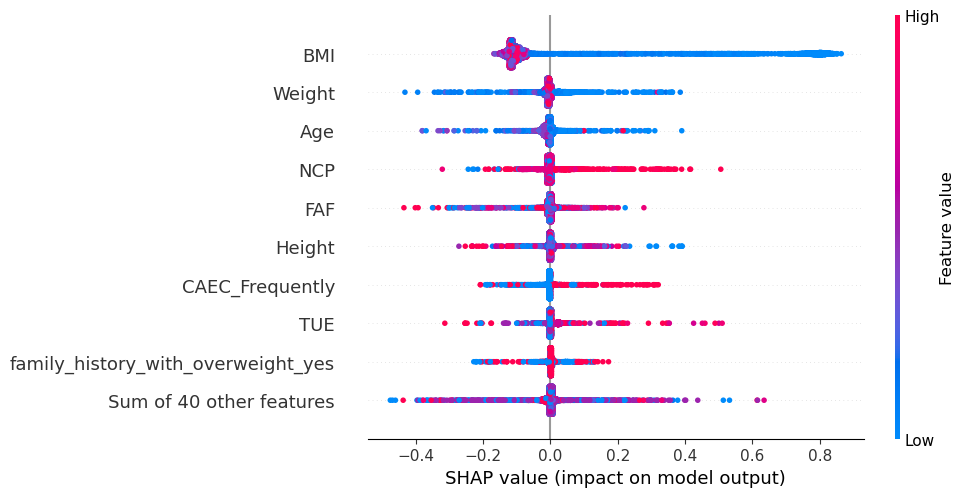

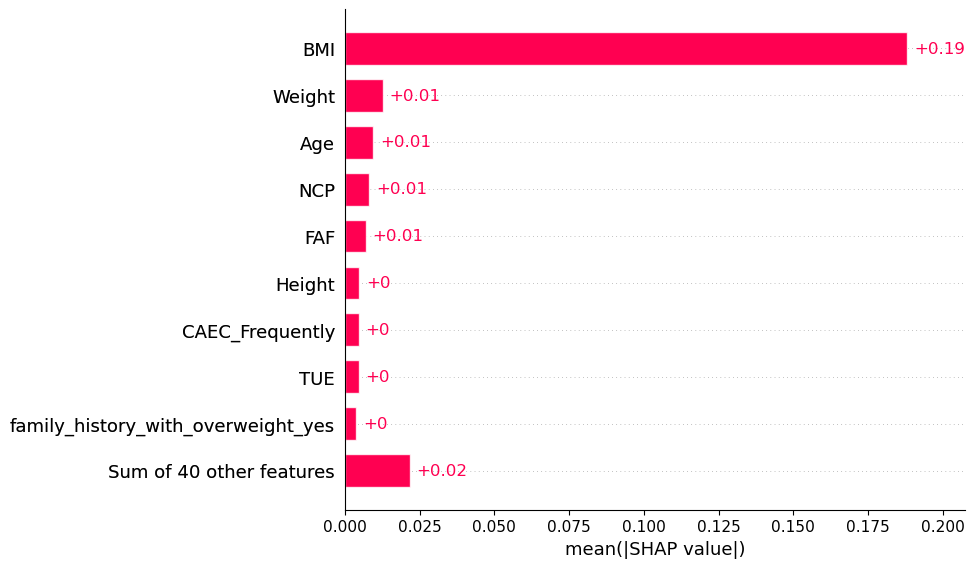

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


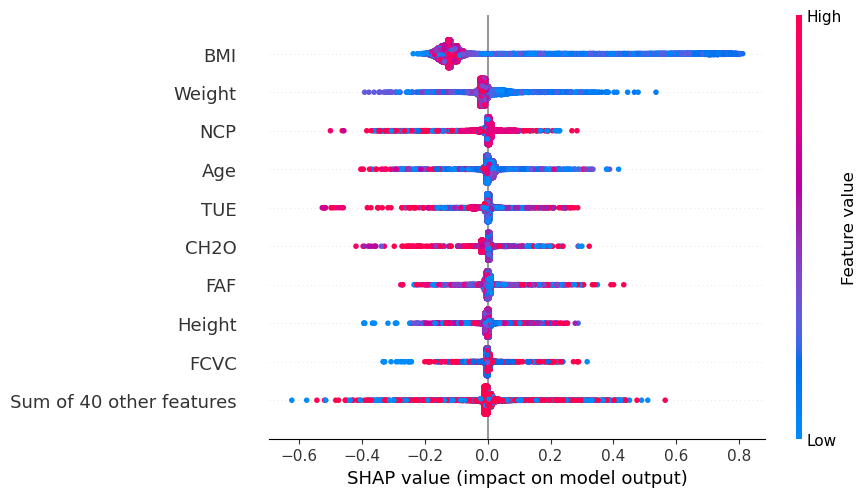

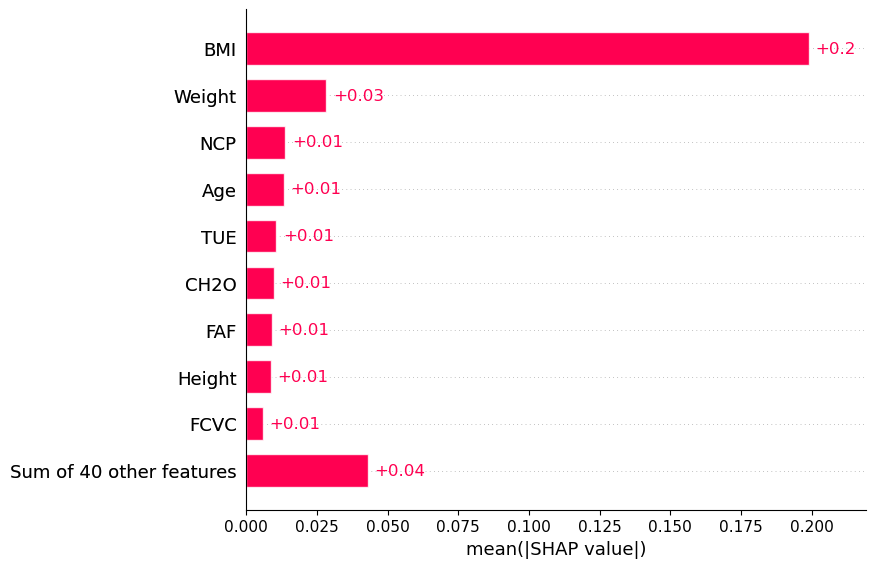

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


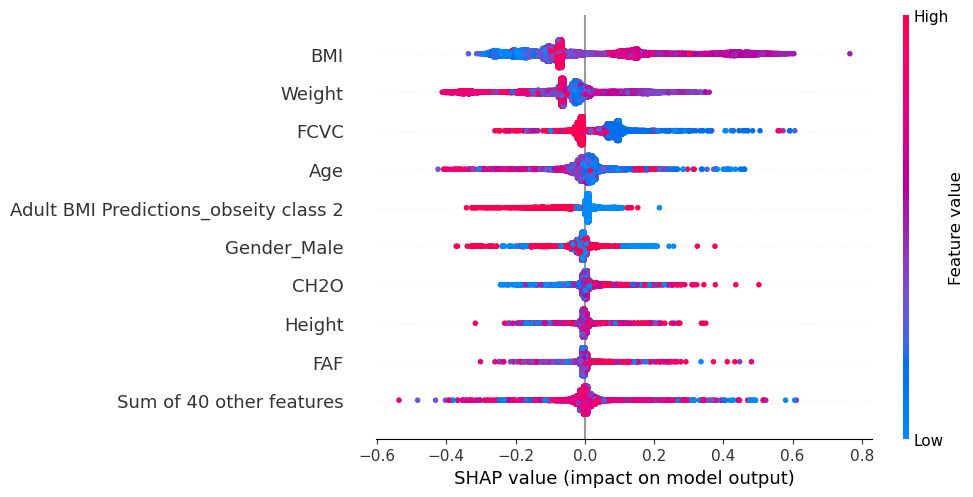

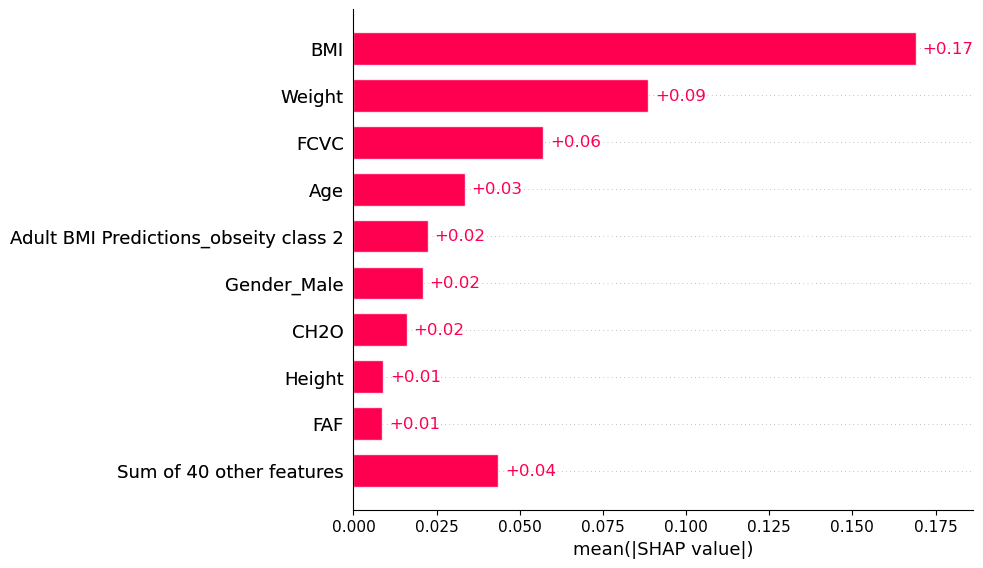

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


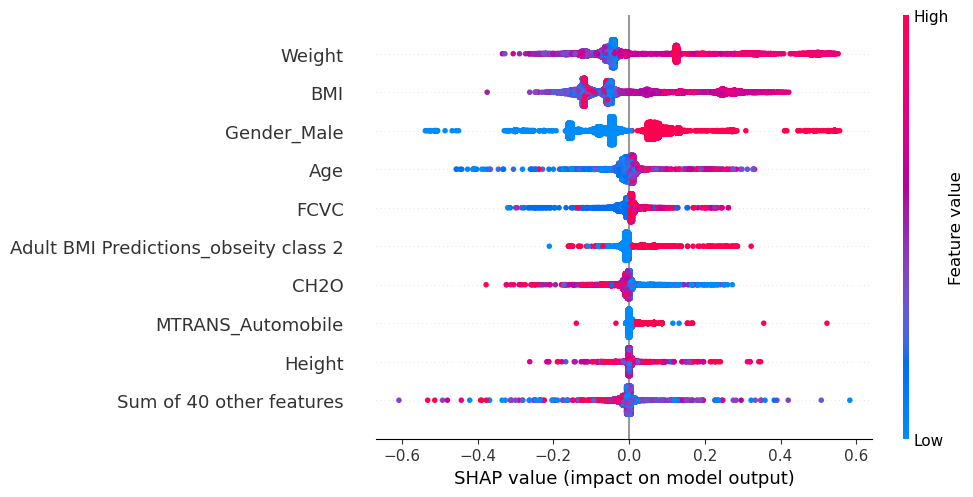

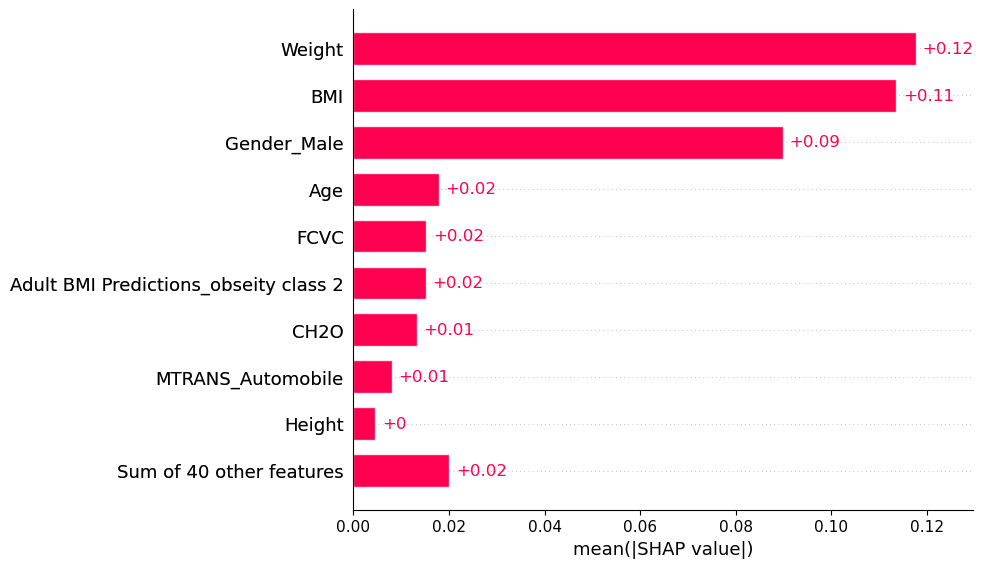

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


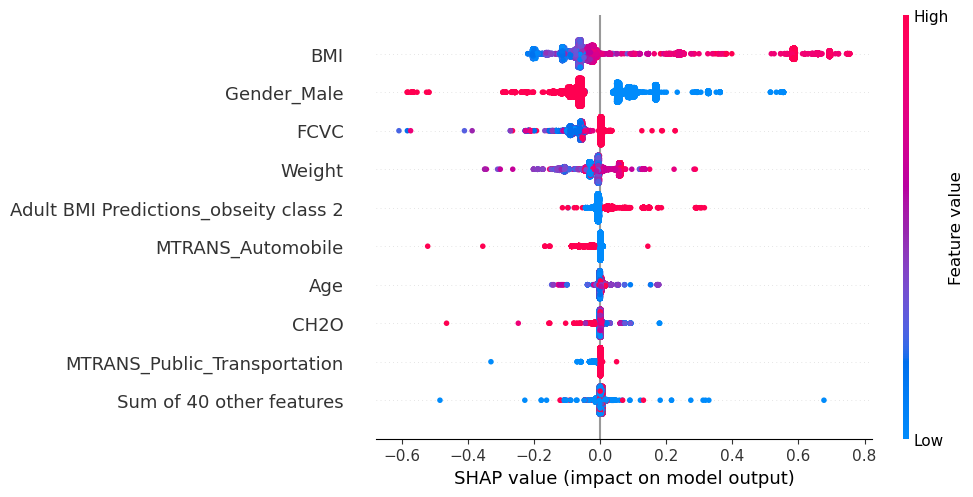

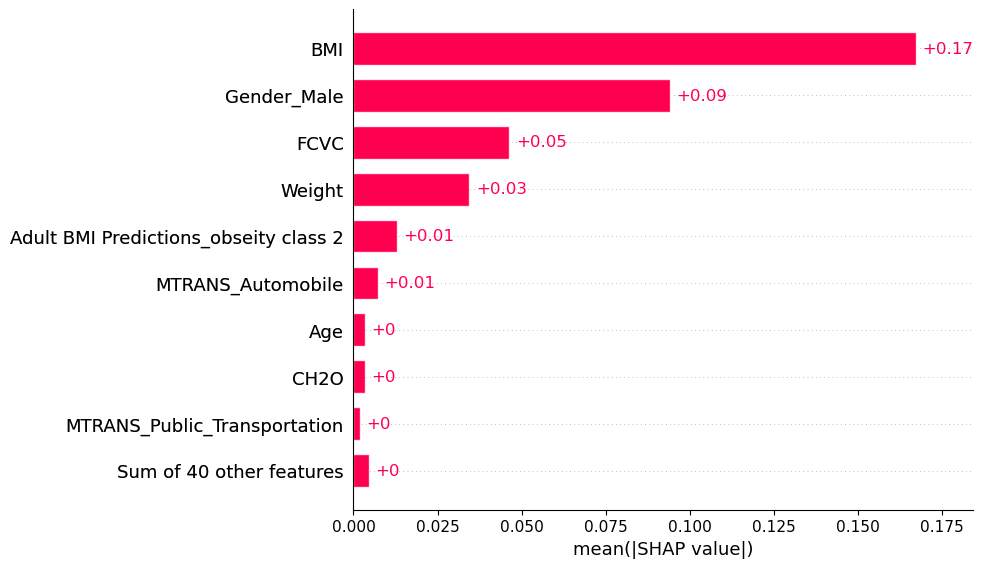

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


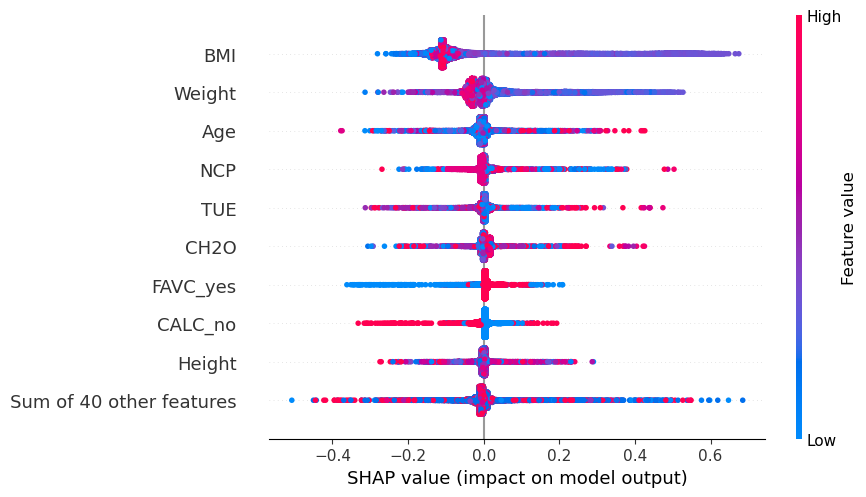

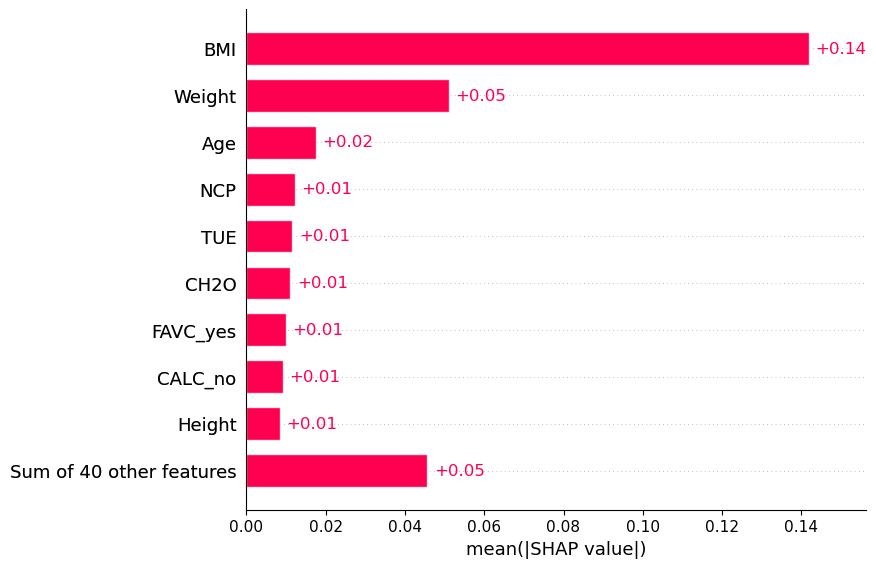

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


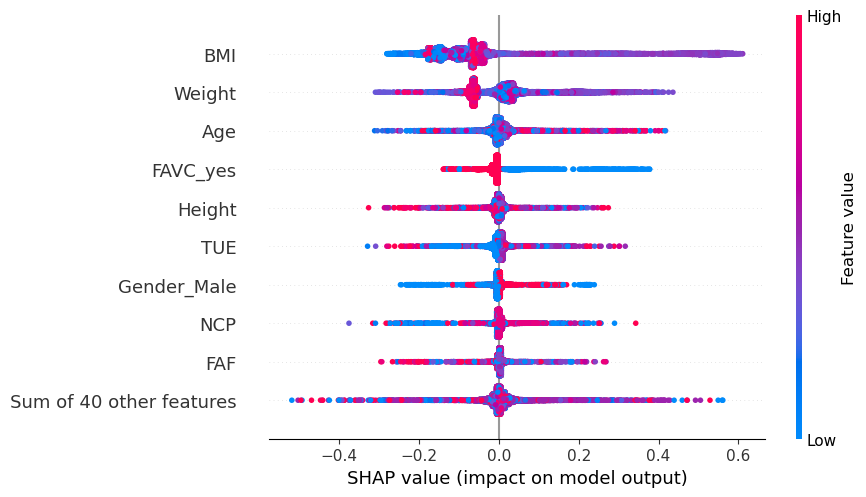

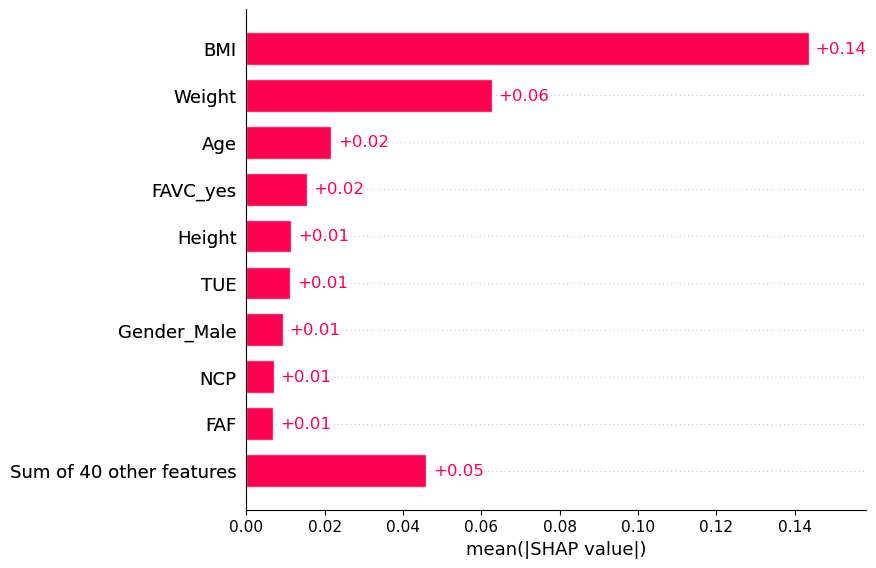

In [32]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(best_model)
shap_values = explainer(dataset)
print(shap_values.shape)

for i in range(shap_values.shape[2]):
    # summarize the effects of all the features
    shap.plots.beeswarm(shap_values[:, :, i])
    
    shap.plots.bar(shap_values[:, :, i])

In [40]:
# Model 2a - Logistic Regression
test = []
models = []
for i, name in enumerate(preprocessed):
    model = LogisticRegression(max_iter = 5000)
    train_results, test_results = train_and_evaluate_classifier(f"Logistic Regression {name}", model, X_train[i], y_train[i], X_test[i], y_test[i], confusion=False)
    test.append(test_results[0])
    models.append(model)
    print()
    
test = np.array(test)
loc_best_test = np.argmax(test)
print(f"Best Preprocessing: {preprocessed[loc_best_test]} - Test Accuracy: {test[loc_best_test]}")
best_model = models[loc_best_test]
dataset = X_train[loc_best_test]

Logistic Regression (Ordinal)


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Logistic Regression (Ordinal Categorical Only - No Scaling)


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Logistic Regression (Ordinal Categorical Only - Standard Scaler)

Logistic Regression (Ordinal Categorical Only - Robust Scaler)

Logistic Regression (One Hot Categorical Only - No Scaling)


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Logistic Regression (One Hot Categorical Only - Standard Scaler)

Logistic Regression (One Hot Categorical Only - Robust Scaler)

Logistic Regression Manual Encoding 1


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Logistic Regression Manual Encoding 2

Best Preprocessing: (One Hot Categorical Only - No Scaling) - Test Accuracy: 0.9673295454545454


(1407, 49, 7)


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


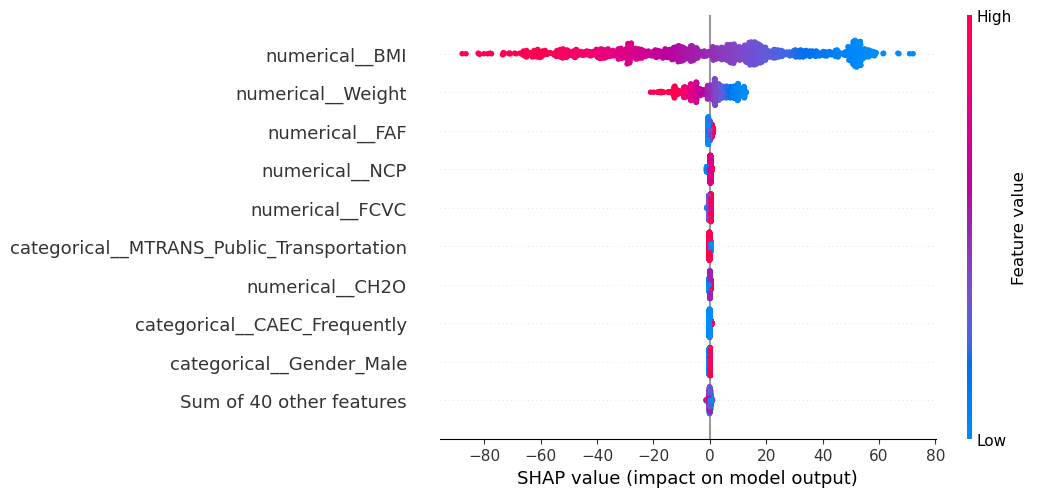

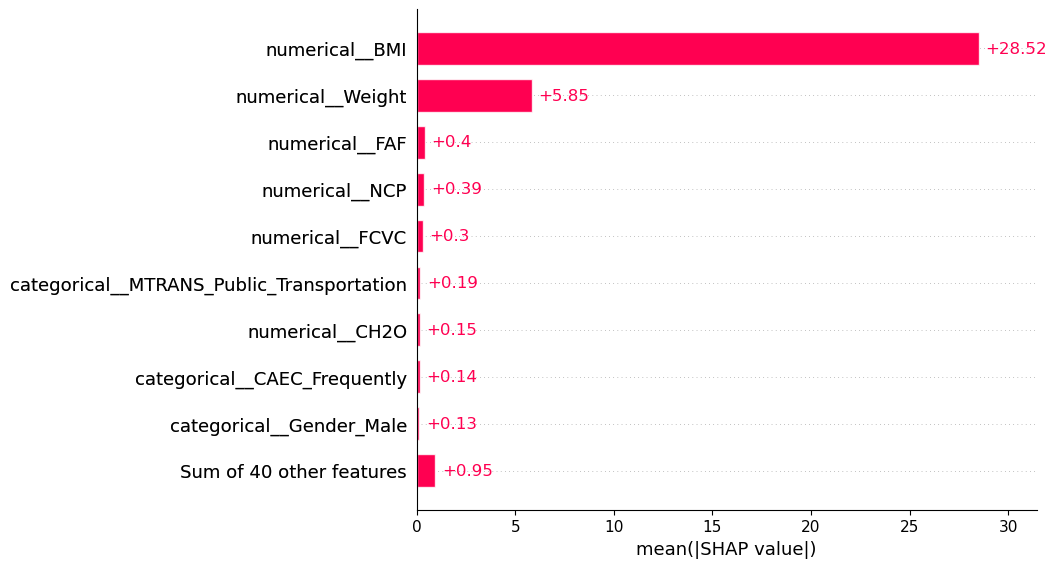

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


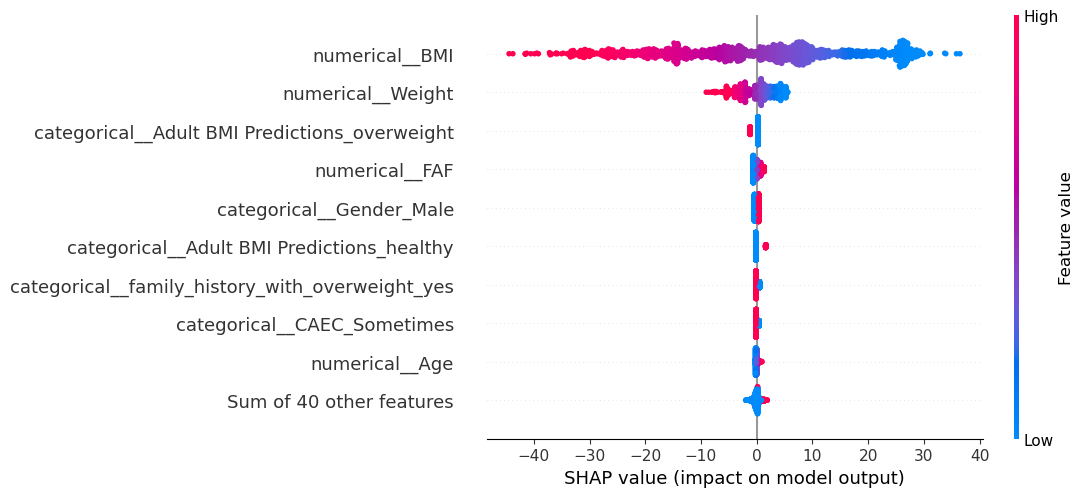

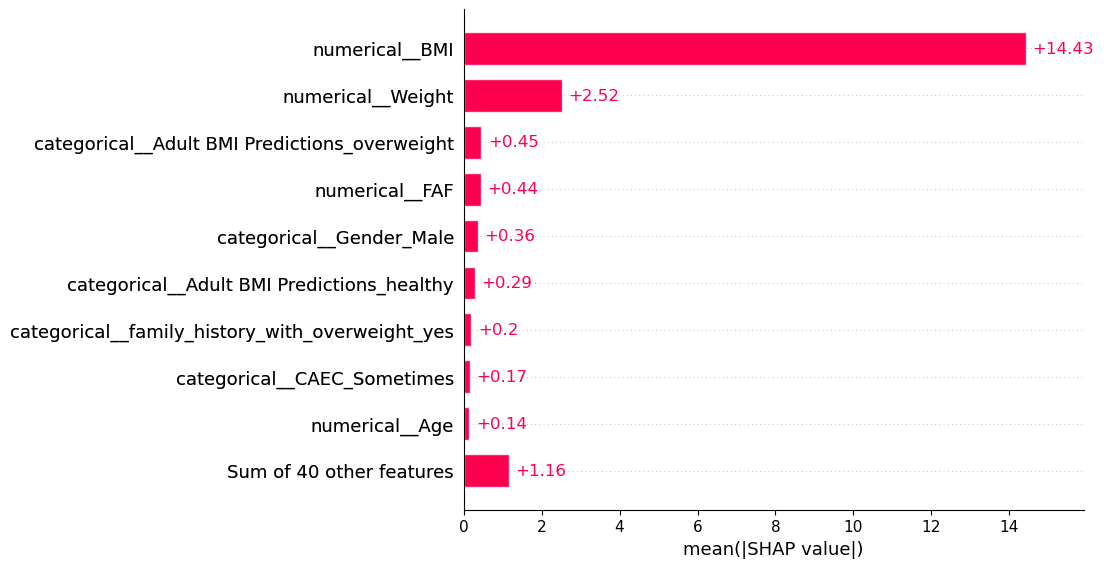

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


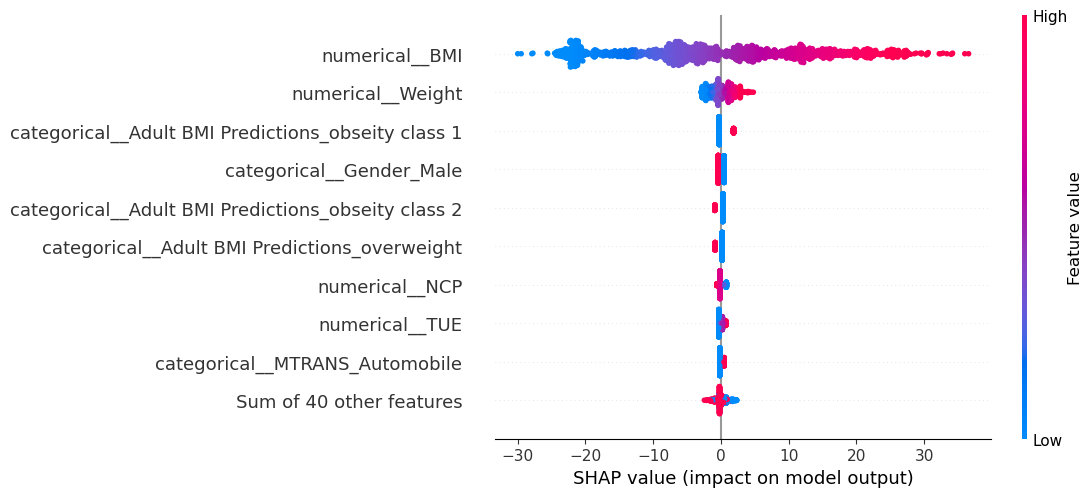

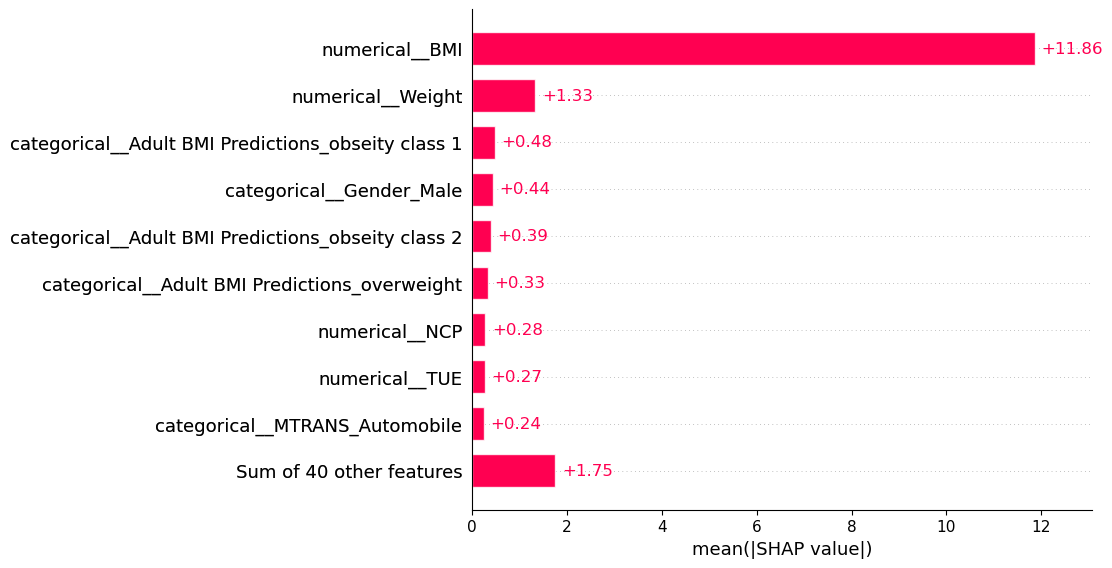

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


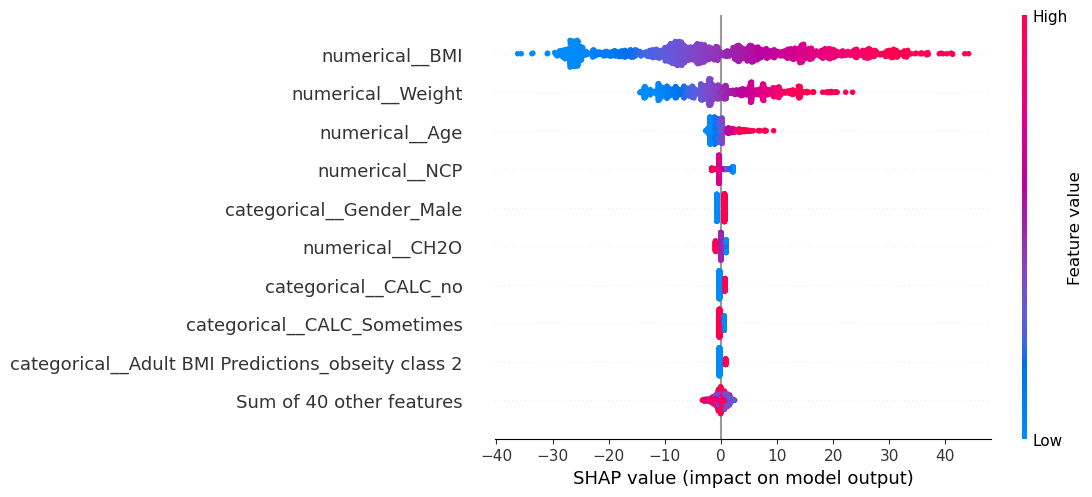

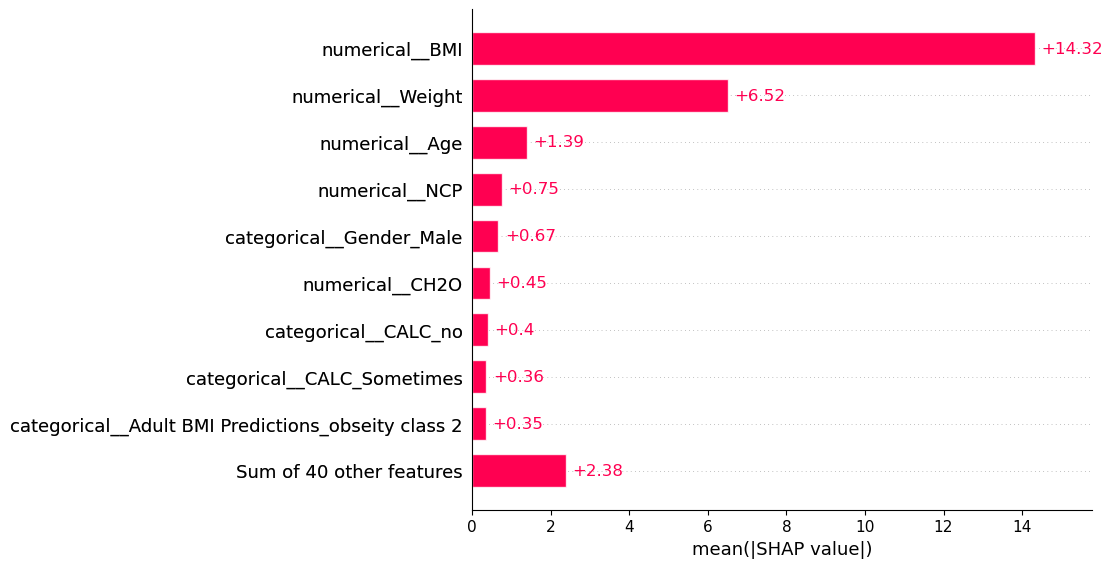

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


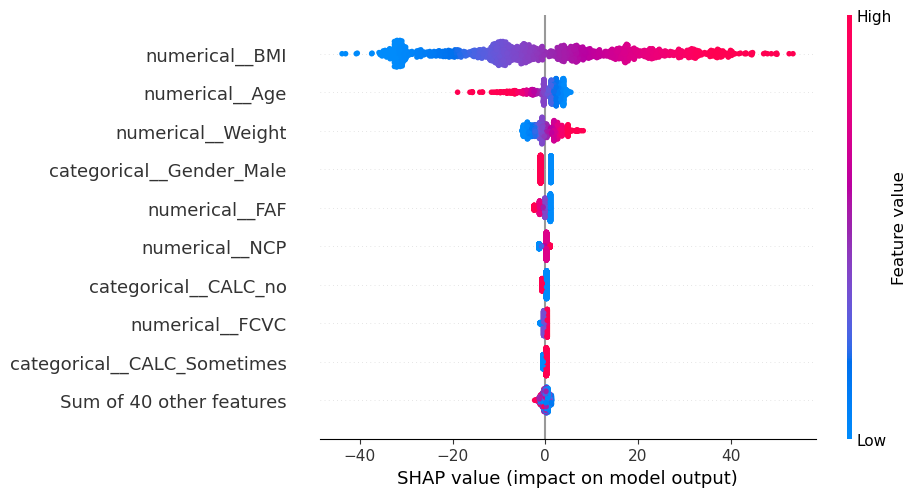

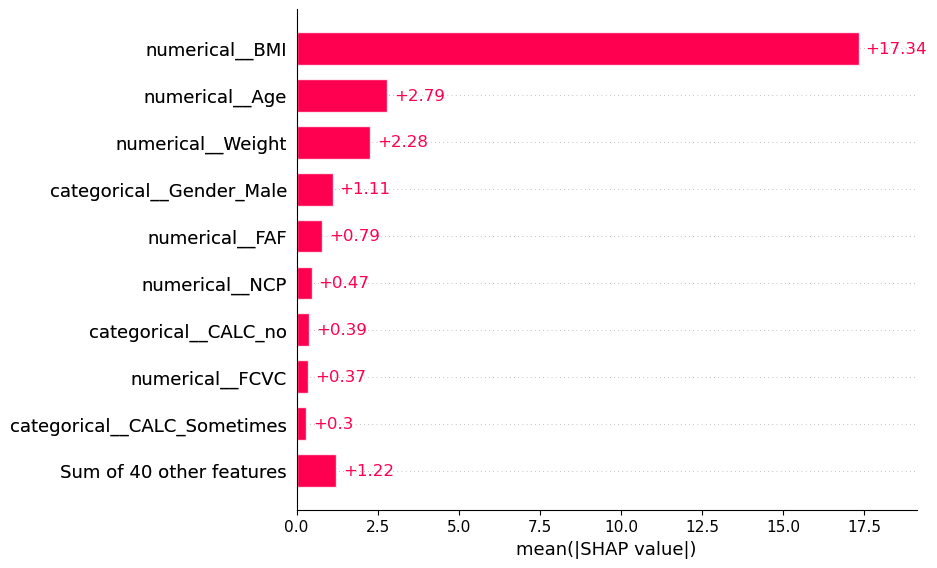

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


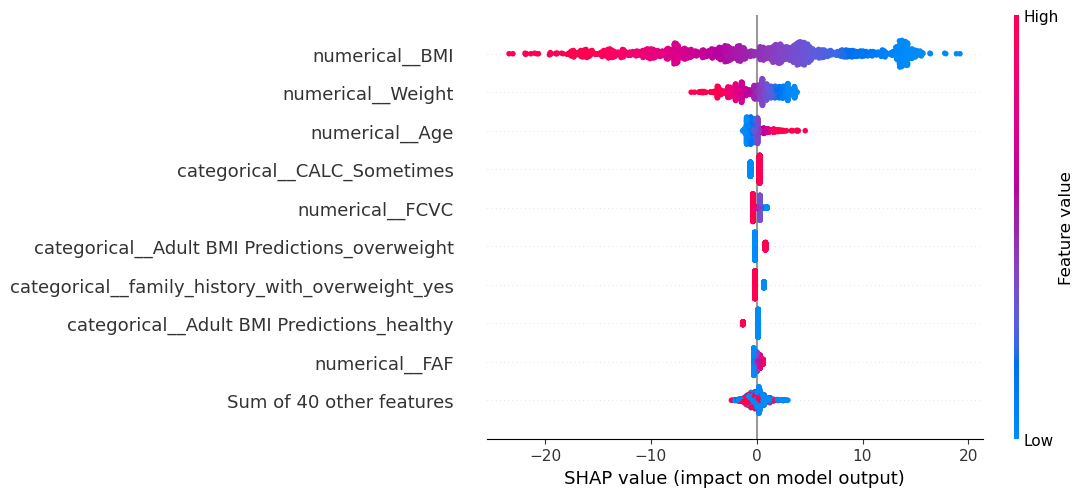

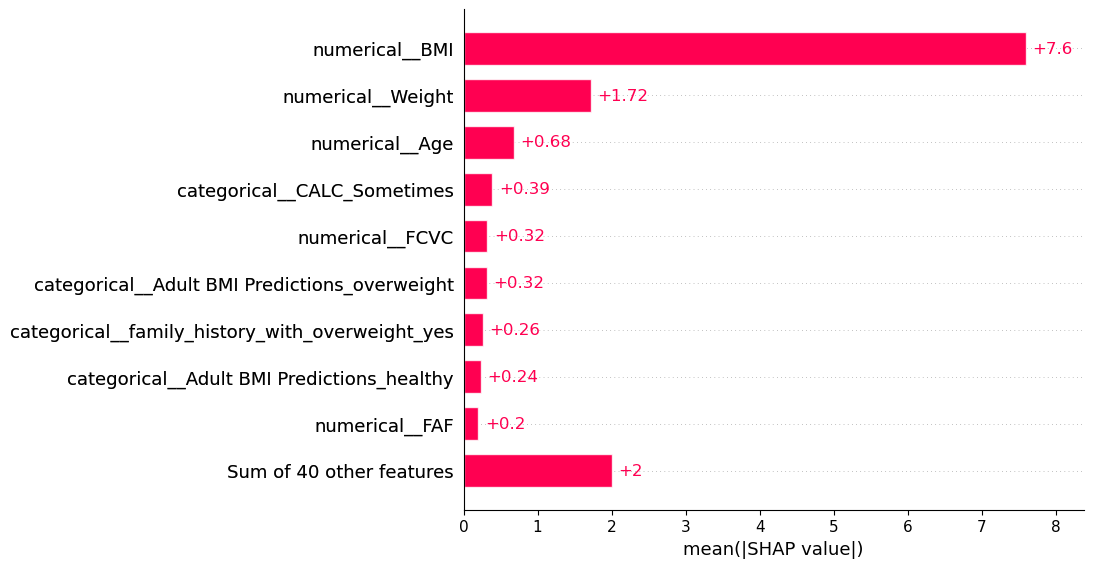

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


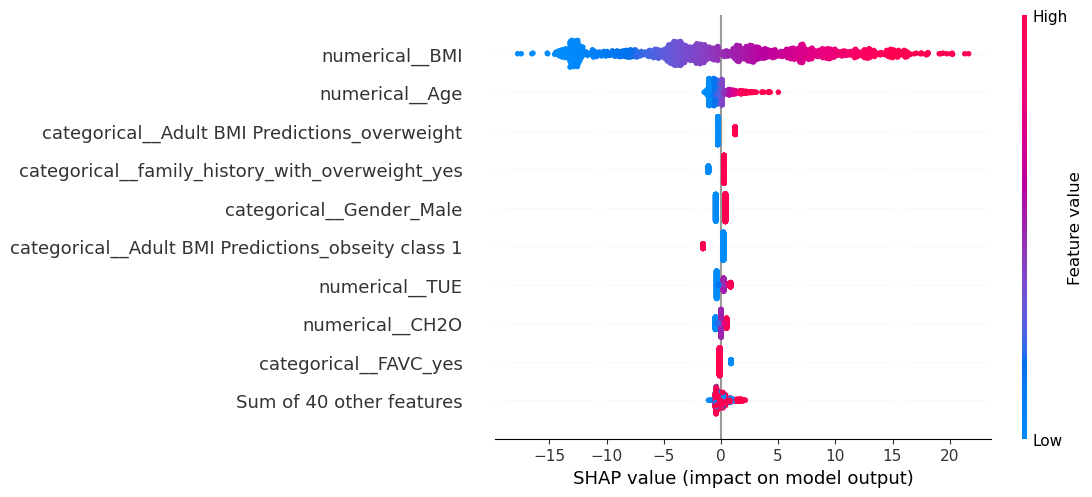

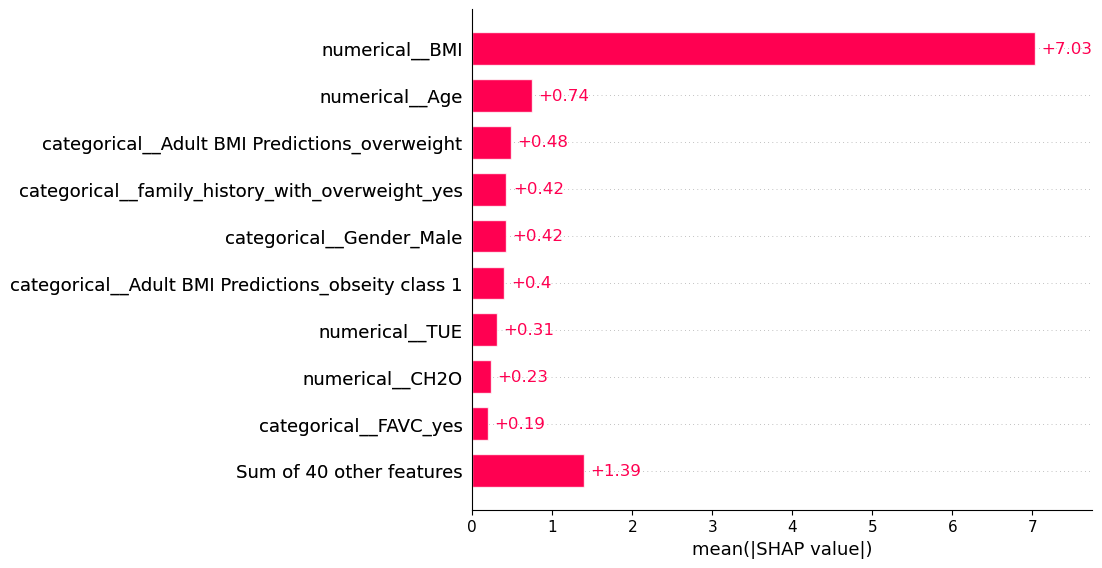

In [41]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.LinearExplainer(best_model, dataset)
shap_values = explainer(dataset)
print(shap_values.shape)

for i in range(shap_values.shape[2]):
    # summarize the effects of all the features
    shap.plots.beeswarm(shap_values[:, :, i])
    
    shap.plots.bar(shap_values[:, :, i])

In [ ]:
# Model 2b - Logistic Regression w/ CV
# warnings.filterwarnings('ignore')

# test = []
# models = []
# for i, name in enumerate(preprocessed):
#     model = LogisticRegressionCV(max_iter = 1000)
#     train_results, test_results = train_and_evaluate_classifier(f"Logistic Regression CV {name}", model, X_train[i], y_train[i], X_test[i], y_test[i], confusion=False)
#     test.append(test_results[0])
#     print()
    
# test = np.array(test)
# loc_best_test = np.argmax(test)
# print(f"Best Preprocessing: {preprocessed[loc_best_test]} - Test Accuracy: {test[loc_best_test]}")
# best_model = models[loc_best_test]
# dataset = X_train[loc_best_test]

In [ ]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
# explainer = shap.LinearExplainer(best_model, dataset)
# shap_values = explainer(dataset)
# print(shap_values.shape)

# for i in range(shap_values.shape[2]):
#     # summarize the effects of all the features
#     shap.plots.beeswarm(shap_values[:, :, i])
    
#     shap.plots.bar(shap_values[:, :, i])

In [ ]:
# Model 3 - MLP
test = []
models = []
for i, name in enumerate(preprocessed):
    model = MLPClassifier(hidden_layer_sizes = (100,), solver='adam', max_iter=200, tol=1e-4, early_stopping=False, alpha=.0001)
    train_results, test_results = train_and_evaluate_classifier(f"MLP {name}", model, X_train[i], y_train[i], X_test[i], y_test[i], confusion=False, supress_outputs=False)
    test.append(test_results[0])
    models.append(model)
    print()
    
test = np.array(test)
loc_best_test = np.argmax(test)
print(f"Best Preprocessing: {preprocessed[loc_best_test]} - Test Accuracy: {test[loc_best_test]}")
best_model = models[loc_best_test]
dataset = X_train[loc_best_test]

In [ ]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
# explainer = shap.KernelExplainer(best_model.predict, dataset)
# shap_values = explainer(dataset)
# print(shap_values.shape)

# for i in range(shap_values.shape[2]):
#     # summarize the effects of all the features
#     shap.plots.beeswarm(shap_values[:, :, i])
    
#     shap.plots.bar(shap_values[:, :, i])

In [ ]:
# Model 4 - KNN
test = []
models = []
for i, name in enumerate(preprocessed):
    model = KNeighborsClassifier()
    train_results, test_results = train_and_evaluate_classifier(f"KNN {name}", model, X_train[i].values, y_train[i], X_test[i].values, y_test[i], confusion=False)
    test.append(test_results[0])
    models.append(model)
    print()
    
test = np.array(test)
loc_best_test = np.argmax(test)
print(f"Best Preprocessing: {preprocessed[loc_best_test]} - Test Accuracy: {test[loc_best_test]}")
best_model = models[loc_best_test]
dataset = X_train[loc_best_test]

In [ ]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
# explainer = shap.Explainer(best_model)
# shap_values = explainer(dataset.values)
# print(shap_values.shape)

# for i in range(shap_values.shape[2]):
#     # summarize the effects of all the features
#     shap.plots.beeswarm(shap_values[:, :, i])
    
#     shap.plots.bar(shap_values[:, :, i])

In [ ]:
# Model 5 - SVM
test = []
models = []
for i, name in enumerate(preprocessed):
    model = SVC(probability=True)
    train_results, test_results = train_and_evaluate_classifier(f"SVM {name}", model, X_train[i], y_train[i], X_test[i], y_test[i], confusion=False)
    test.append(test_results[0])
    models.append(model)
    print()
    
test = np.array(test)
loc_best_test = np.argmax(test)
print(f"Best Preprocessing: {preprocessed[loc_best_test]} - Test Accuracy: {test[loc_best_test]}")
best_model = models[loc_best_test]
dataset = X_train[loc_best_test]

In [ ]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
# explainer = shap.KernelExplainer(best_model.predict, dataset)
# shap_values = explainer(dataset)
# print(shap_values.shape)

# for i in range(shap_values.shape[2]):
#     # summarize the effects of all the features
#     shap.plots.beeswarm(shap_values[:, :, i])
    
#     shap.plots.bar(shap_values[:, :, i])

In [ ]:
# Model 6a - LDA
test = []
models = []
for i, name in enumerate(preprocessed):
    model = LinearDiscriminantAnalysis()
    if sci.sparse.issparse(X_train[i]) == True:
        train_results, test_results = train_and_evaluate_classifier(f"LDA {name}", model, X_train[i].to_records(), y_train[i], X_test[i], y_test[i], confusion=False)
    else:
        train_results, test_results = train_and_evaluate_classifier(f"LDA {name}", model, X_train[i], y_train[i], X_test[i], y_test[i], confusion=False)
    test.append(test_results[0])
    models.append(model)
    print()
    
test = np.array(test)
loc_best_test = np.argmax(test)
print(f"Best Preprocessing: {preprocessed[loc_best_test]} - Test Accuracy: {test[loc_best_test]}")
best_model = models[loc_best_test]
dataset = X_train[loc_best_test]

In [ ]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.LinearExplainer(best_model, dataset)
shap_values = explainer(dataset)
print(shap_values.shape)

for i in range(shap_values.shape[2]):
    # summarize the effects of all the features
    shap.plots.beeswarm(shap_values[:, :, i])
    
    shap.plots.bar(shap_values[:, :, i])

In [ ]:
# Model 6b - QDA
test = []
models = []
for i, name in enumerate(preprocessed):
    model = QuadraticDiscriminantAnalysis(reg_param=0.125)
    if sci.sparse.issparse(X_train[i]) or sci.sparse.issparse(X_test[i]) == True:
        train_results, test_results = train_and_evaluate_classifier(f"QDA {name}", model, X_train[i].values, y_train[i], X_test[i].values, y_test[i], confusion=False)
    else:
        train_results, test_results = train_and_evaluate_classifier(f"QDA {name}", model, X_train[i], y_train[i], X_test[i], y_test[i], confusion=False)
    test.append(test_results[0])
    models.append(model)
    print()
    
test = np.array(test)
loc_best_test = np.argmax(test)
print(f"Best Preprocessing: {preprocessed[loc_best_test]} - Test Accuracy: {test[loc_best_test]}")
best_model = models[loc_best_test]
dataset = X_train[loc_best_test]

In [ ]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
# explainer = shap.KernelExplainer(best_model.predict, dataset)
# shap_values = explainer(dataset.values)
# print(shap_values.shape)

# for i in range(shap_values.shape[2]):
#     # summarize the effects of all the features
#     shap.plots.beeswarm(shap_values[:, :, i])
    
#     shap.plots.bar(shap_values[:, :, i])

In [ ]:
# Model 7a - Gaussian Naive Bayes
test = []
models = []
indexes = [0, 1, 2, 3, 4, 5, 6]
for i in indexes:
    name = preprocessed[i]
    model = GaussianNB()
    if sci.sparse.issparse(X_train[i]) or sci.sparse.issparse(X_test[i]) == True:
        train_results, test_results = train_and_evaluate_classifier(f"Gaussian Naive Bayes {name}", model, X_train[i].toarray(), y_train[i], X_test[i].toarray(), y_test[i], confusion=False)
    else:
        train_results, test_results = train_and_evaluate_classifier(f"Gaussian Naive Bayes {name}", model, X_train[i], y_train[i], X_test[i], y_test[i], confusion=False)
    test.append(test_results[0])
    models.append(model)
    print()
    
test = np.array(test)
loc_best_test = np.argmax(test)
print(f"Best Preprocessing: {preprocessed[loc_best_test]} - Test Accuracy: {test[loc_best_test]}")
best_model = models[loc_best_test]
dataset = X_train[loc_best_test]

In [ ]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
# explainer = shap.KernelExplainer(best_model.predict, dataset)
# shap_values = explainer(dataset.values)
# print(shap_values.shape)

# for i in range(shap_values.shape[2]):
#     # summarize the effects of all the features
#     shap.plots.beeswarm(shap_values[:, :, i])
    
#     shap.plots.bar(shap_values[:, :, i])

In [ ]:
# Model 7e - Categorical Naive Bayes
test = []
indexes = [0, 1, 4]
for i in indexes:
    name = preprocessed[i]
    model = CategoricalNB()
    if sci.sparse.issparse(X_train[i]) or sci.sparse.issparse(X_test[i]) == True:
        train_results, test_results = train_and_evaluate_classifier(f"Categorical Naive Bayes {name}", model, X_train[i].toarray(), y_train[i], X_test[i].toarray(), y_test[i], confusion=False)
    else:
        train_results, test_results = train_and_evaluate_classifier(f"Categorical Naive Bayes {name}", model, X_train[i], y_train[i], X_test[i], y_test[i], confusion=False)
    test.append(test_results[0])
    models.append(model)
    print()
    
test = np.array(test)
loc_best_test = np.argmax(test)
print(f"Best Preprocessing: {preprocessed[indexes[loc_best_test]]} - Test Accuracy: {test[loc_best_test]}")
best_model = models[loc_best_test]
dataset = X_train[loc_best_test]

In [ ]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
# explainer = shap.KernelExplainer(best_model.predict, dataset.values)
# shap_values = explainer(dataset.values)
# print(shap_values.shape)

# for i in range(shap_values.shape[2]):
#     # summarize the effects of all the features
#     shap.plots.beeswarm(shap_values[:, :, i])
    
#     shap.plots.bar(shap_values[:, :, i])